In [1]:
import numpy as np
from scipy.stats import norm, t
import math
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
def simulate_brownian_motion_paths(S0, r, sigma, T, M, I):
    """
    Simulate stock price paths using geometric Brownian motion.
    :param S0: Initial stock price.
    :param r: Risk-free rate.
    :param sigma: Volatility of the underlying asset.
    :param T: Time to maturity.
    :param M: Number of time steps .
    :param I: Number of simulation paths.
    :return: Simulated paths array.
    """
    dt = T / M
    paths = np.zeros((M + 1, I))
    paths[0] = S0
    for t in range(1, M + 1):
        Z = np.random.normal(0, np.sqrt(dt), I)
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * Z)
    return paths

def simulate_student_t_paths(S0, r, sigma, T, M, I, v):
    """
    Simulate stock price paths with increments distributed according to a Student-t distribution.
    :param S0: Initial stock price.
    :param r: Risk-free rate.
    :param sigma: Volatility of the underlying asset.
    :param T: Time to maturity.
    :param M: Number of time steps .
    :param I: Number of simulation paths.
    :param v: Degrees of freedom for the Student-t distribution.
    :return: Simulated paths array.
    """
    dt = T / M
    paths = np.zeros((M + 1, I))
    paths[0] = S0
    for i in range(1, M + 1):
        Z = t.rvs(df=v, size=I)
        paths[i] = paths[i - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

def calculate_delta(S, K, r, sigma, T, t):
    """
    Calculate the delta of an option using the Black-Scholes formula.
    :param S: Current stock price.
    :param K: Strike price of the option.
    :param r: Risk-free rate.
    :param sigma: Volatility of the underlying asset.
    :param T: Time to maturity.
    :param t: Current time.
    :return: Delta value.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * np.sqrt(T - t))
    return norm.cdf(d1)

def black_scholes_price(S, K, r, sigma, T, t, option_type='call'):
    """
    Calculate the Black-Scholes option price.
    :param S: Current stock price.
    :param K: Strike price.
    :param r: Risk-free interest rate.
    :param sigma: Volatility of the stock.
    :param T: Time to maturity.
    :param t: Current time.
    :param option_type: Type of the option - 'call' or 'put'.
    :return: Price of the option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * (T - t)) * norm.cdf(d2)
    else:  # put option
        return K * np.exp(-r * (T - t)) * norm.cdf(-d2) - S * norm.cdf(-d1)



def calculate_var_es(losses, confidence_level=0.95):
    """
    Calculate VaR and ES for a series of losses.
    :param losses: Array of losses.
    :param confidence_level: Confidence level for VaR and ES calculation.
    :return: VaR and ES values.
    """

    sorted_losses = np.sort(losses)
    var_index = int((1 - confidence_level) * len(sorted_losses))
    VaR = sorted_losses[var_index]
    ES = sorted_losses[:var_index].mean()
    return VaR, ES



def calculate_portfolio_value(price_path, K, r, sigma, T):
    """
    Calculate the delta-hedged self-financing portfolio values
    
    """
     
    M = len(price_path) - 1  # Number of time steps
    dt = T / M  # Length of each time step
    
    # Calculate initial option price, delta, and theta
    C0 = black_scholes_price(price_path[0], K, r, sigma, T, 0)
    delta_0 = calculate_delta(price_path[0], K, r, sigma, T, 0)
    theta_call = -1  # The number of call options held
    theta_stock = 0-(delta_0*theta_call)  # To ensure delta-hedging
    portfolio_values = []
    
    # Initialize portfolio value
    portfolio_value = theta_stock * price_path[0] + theta_call * C0
    portfolio_shares={'call':1,
               'stock':theta_stock}
    portfolio_values.append(portfolio_value)

    # Iterate through the price path to update the portfolio
    for t in range(1,M):
        # stock price
        
        St = price_path[t]
        
        # Calculate option price at t+1 and delta at t+1
        Ct = black_scholes_price(St, K, r, sigma, T , dt * (t))
        delta_t = calculate_delta(St, K, r, sigma, T , dt * (t))
        portfolio_value = St * portfolio_shares['stock'] + portfolio_shares['call'] * Ct
        portfolio_values.append(portfolio_value)
        # # Update theta for call and stock based on delta-hedging and self-financing condition
        # theta_call = (portfolio_shares['stock']*St+portfolio_shares['call']*Ct)/(Ct-delta_t*St) # From the delta-hedging equation
        
        # theta_stock = -theta_call * delta_t  # From the self-financing condition

        # Set up the coefficient matrix A and constant vector b
        A = np.array([[St, Ct], [1,delta_t]])
        b = np.array([St * portfolio_shares['stock'] + portfolio_shares['call'] * Ct, 0])

        # Solve for the unknowns theta_{t+1}^S and theta_{t+1}^C
        # theta_t_plus_1 = np.linalg.solve(A, b)
        try:
            portfolio_shares['stock'],portfolio_shares['call'] = np.linalg.solve(A, b)
        except:
            continue
  
 
    
    return portfolio_values

    

def calculate_portfolio_VaR(portfolioprice,confidence_level):
    """
    This function is used to calculate the portfolio loss (e.g simple return, or log return)
    """
    

    portfolioprice = pd.Series(portfolioprice)
    
    # Calculate loss (considering them as 'losses')
    loss = portfolioprice - portfolioprice.shift(-1).dropna()

    # Sort the log returns in ascending order (since losses are negative, this actually sorts them by severity)
    
    sorted_loss = loss.sort_values(ascending=True)
    # Calculate VaR given confidence level
    
    var = sorted_loss.quantile(1 - confidence_level)

    return var


def calculate_portfolio_ES(portfolioprice,confidence_level):
    """
    This function is used to calculate the expected shortfall (e.g simple return, or log return)
    """
    
    portfolioprice = pd.Series(portfolioprice)
    
    # Calculate loss (considering them as 'losses')
    loss = portfolioprice - portfolioprice.shift(-1).dropna()

    # Sort the log returns in ascending order (since losses are negative, this actually sorts them by severity)
    
    sorted_loss = loss.sort_values(ascending=True)
    # Calculate VaR given confidence level
    
    var = sorted_loss.quantile(1 - confidence_level)

    # Calculate Expected Shortfall (ES)
    es = sorted_loss[sorted_loss >= var].mean()

    return es






In [2]:
# Consider the different strike prices and different Vailty

results = {}

for K in tqdm((100,140,180)):

    
    for sigma in tqdm((0.2,0.4)):

        
        key = f'K={K}_sigma={sigma}'
        results[key] = {
            'VaRs_Brownian': [],
            'VaRs_Student_t_1': [],
            'VaRs_Student_t_2': [],
            'VaRs_Student_t_3': [],
            'ES_Brownian': [],
            'ES_Student_t_1': [],
            'ES_Student_t_2': [],
            'ES_Student_t_3': []
        }
    
        # Parameters for simulation
        S0 = 100  # Initial stock price
        #K = 100  # Strike price
        T = 1.0  # Time to maturity (1 year)
        r = 0.05  # Risk-free rate
        #sigma = 0.2  # Volatility of the underlying asset
        M = 365  # Number of time steps 
        I = 1000  # Number of simulation paths
        v_1 = 4  # Degrees of freedom for the Student-t distribution
        v_2 = 6  # Degrees of freedom for the Student-t distribution
        v_3 = 8  # Degrees of freedom for the Student-t distribution
        dt = T / M  # Length of each time step in years

        # Simulate paths using both methods
        paths_brownian = simulate_brownian_motion_paths(S0, r, sigma, T, M, I)
        paths_student_t_1 = simulate_student_t_paths(S0, r, sigma, T, M, I, v_1)
        paths_student_t_2 = simulate_student_t_paths(S0, r, sigma, T, M, I, v_2)
        paths_student_t_3 = simulate_student_t_paths(S0, r, sigma, T, M, I, v_3)



        # VaRs_Brownian = []
        # VaRs_Student_t_1 = []
        # VaRs_Student_t_2 = []
        # VaRs_Student_t_3 = []
        # ES_Brownian=[]
        # ES_Student_t_1 = []
        # ES_Student_t_2 = []
        # ES_Student_t_3 = []

        # monte carlo simulation for all the price paths
        for i in range(I):


            # Brownian
            price_path=paths_brownian.T[i]
            portfolioprice = calculate_portfolio_value(price_path, K, r, sigma, T)
            var = calculate_portfolio_VaR(portfolioprice, confidence_level=0.95)
            ES = calculate_portfolio_ES(portfolioprice, confidence_level=0.95)
            results[key]['VaRs_Brownian'].append(var)
            results[key]['ES_Brownian'].append(ES)

            # VaRs_Brownian.append(var)
            # ES_Brownian.append(ES)

            # Student t , df = 4
            price_path=paths_student_t_1.T[i]
            portfolioprice = calculate_portfolio_value(price_path, K, r, sigma, T)
            var = calculate_portfolio_VaR(portfolioprice, confidence_level=0.95)
            ES = calculate_portfolio_ES(portfolioprice,confidence_level=0.95)
            results[key]['VaRs_Student_t_1'].append(var)
            results[key]['ES_Student_t_1'].append(ES)

            # VaRs_Student_t_1.append(var)
            # ES_Student_t_1.append(ES)

            # Student t , df = 6
            price_path=paths_student_t_2.T[i]
            portfolioprice = calculate_portfolio_value(price_path, K, r, sigma, T)
            var = calculate_portfolio_VaR(portfolioprice, confidence_level=0.95)
            ES = calculate_portfolio_ES(portfolioprice,confidence_level=0.95)
            results[key]['VaRs_Student_t_2'].append(var)
            results[key]['ES_Student_t_2'].append(ES)
            # VaRs_Student_t_2.append(var)
            # ES_Student_t_2.append(ES)


            # Student t , df = 8
            price_path=paths_student_t_3.T[i]
            portfolioprice = calculate_portfolio_value(price_path, K, r, sigma, T)
            var = calculate_portfolio_VaR(portfolioprice, confidence_level=0.95)
            ES = calculate_portfolio_ES(portfolioprice,confidence_level=0.95)
            results[key]['VaRs_Student_t_3'].append(var)
            results[key]['ES_Student_t_3'].append(ES)
            # VaRs_Student_t_3.append(var)
            # ES_Student_t_3.append(ES)

            
ResultTable = pd.DataFrame.from_dict({(i, j): results[i][j] 
                             for i in results.keys() 
                             for j in results[i].keys()},
                            orient='index')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:22<?, ?it/s]


KeyboardInterrupt: 

In [6]:
# the Monte Carlo Result table
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
"(K=100_sigma=0.2, VaRs_Brownian)",-0.021021,-0.018361,-0.079407,-0.164902,-0.125981,-0.049351,-0.025761,-0.043116,-0.201657,-0.017234,-0.021378,-0.215425,-0.065567,-0.232195,-0.029500,-0.086202,-0.027293,-0.076822,-0.020597,-0.031154
"(K=100_sigma=0.2, VaRs_Student_t_1)",-0.023261,-0.025593,-0.046760,-0.024248,-0.017337,-0.014556,-0.020735,-0.069035,-0.031090,-0.080399,-0.031431,-0.060161,-0.058157,-0.019093,-0.165310,-0.140663,-0.025603,-0.060805,-0.051407,-0.039796
"(K=100_sigma=0.2, VaRs_Student_t_2)",-0.026329,-0.146250,-0.026760,-0.025479,-0.037696,-0.041331,-0.223993,-0.034303,-0.022008,-0.143567,-0.031520,-0.134035,-0.038604,-0.015445,-0.053017,-0.021462,-0.035703,-0.153432,-0.047256,-0.027500
"(K=100_sigma=0.2, VaRs_Student_t_3)",-0.020886,-0.099375,-0.290789,-0.075555,-0.176743,-0.032364,-0.294392,-0.020401,-0.022100,-0.049006,-0.111608,-0.103658,-0.115266,-0.027553,-0.024429,-0.203083,-0.041225,-0.097157,-0.290515,-0.034356
"(K=100_sigma=0.2, ES_Brownian)",-0.009159,-0.009476,-0.002572,0.006119,-0.001028,-0.010158,-0.008287,-0.006519,0.024039,-0.009074,-0.009474,0.005926,0.003681,0.074755,-0.010013,0.000273,-0.005618,0.002359,-0.009363,-0.009572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(K=180_sigma=0.4, VaRs_Student_t_3)",-0.079679,-0.117445,-0.106879,-0.107364,-0.050770,-0.051975,-0.125681,-0.031935,-0.026831,-0.061025,-0.080334,-0.069689,-0.052003,-0.098867,-0.095097,-0.023493,-0.081872,-0.048735,-0.040746,-0.073065
"(K=180_sigma=0.4, ES_Brownian)",0.007545,0.002951,0.010615,-0.001262,-0.001362,-0.001672,-0.002059,0.002939,0.015851,0.005506,0.016886,0.005401,0.020322,0.010421,0.008442,-0.000217,0.024389,0.023129,0.012166,0.017994
"(K=180_sigma=0.4, ES_Student_t_1)",0.018623,0.118567,0.024075,0.032193,0.021525,0.019445,0.008040,0.035888,0.006876,0.035695,0.015959,13.307059,0.021182,0.040289,0.016102,0.034147,0.046720,0.024990,0.047459,0.012171
"(K=180_sigma=0.4, ES_Student_t_2)",0.021424,0.035723,0.025499,0.018093,0.020601,0.052275,0.025353,0.031405,0.010568,0.038069,0.019164,0.026686,0.014505,0.006232,0.038355,0.006530,0.019054,0.026511,0.004203,0.019123


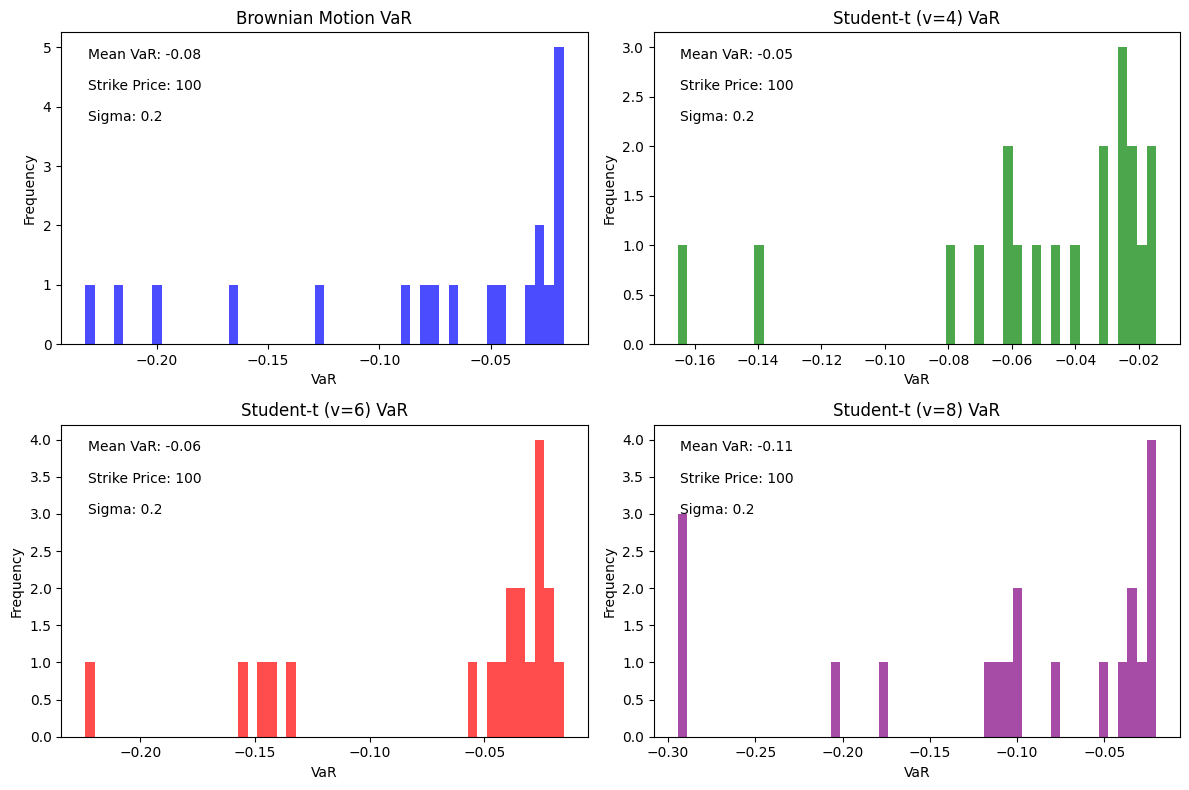

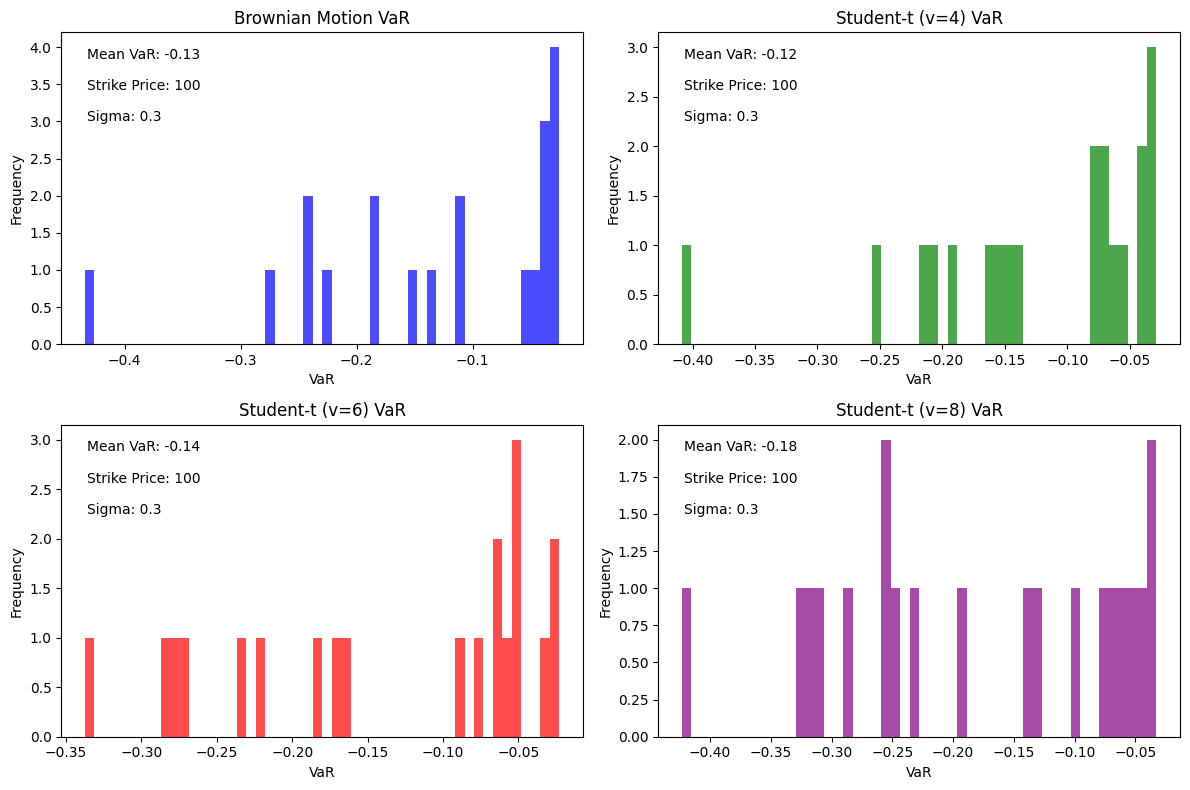

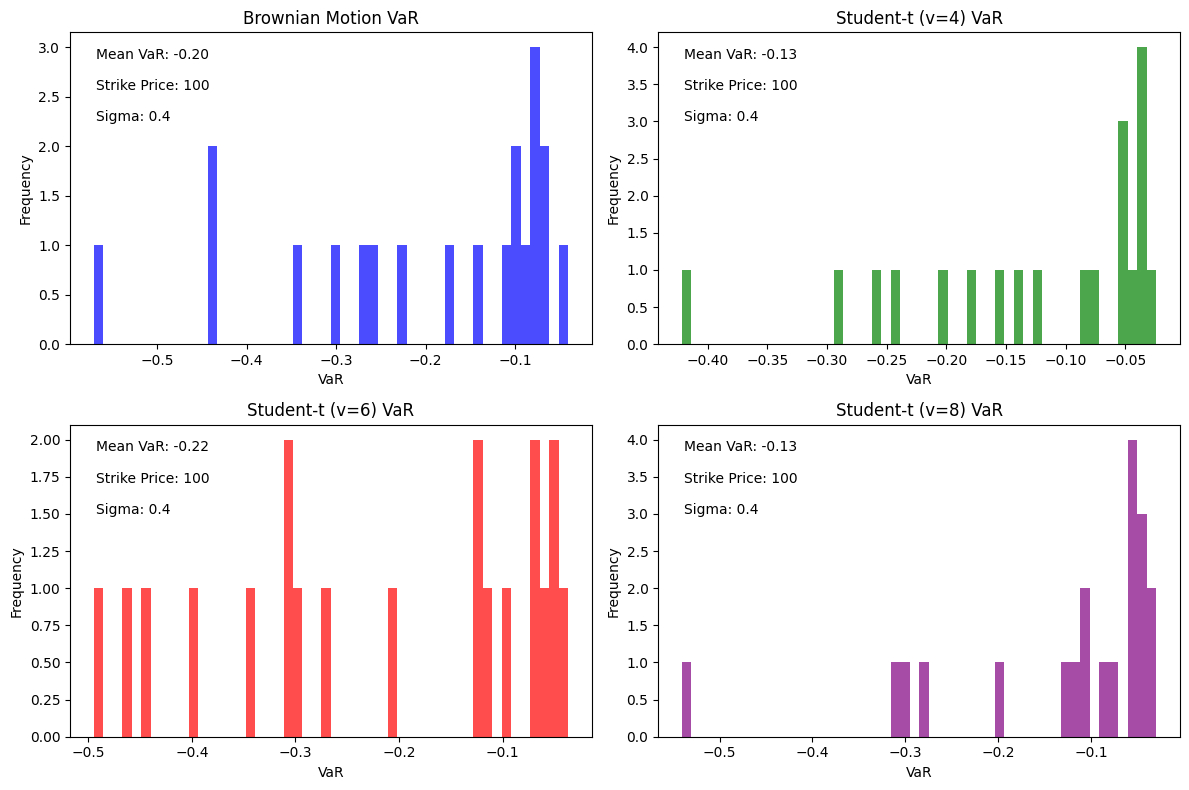

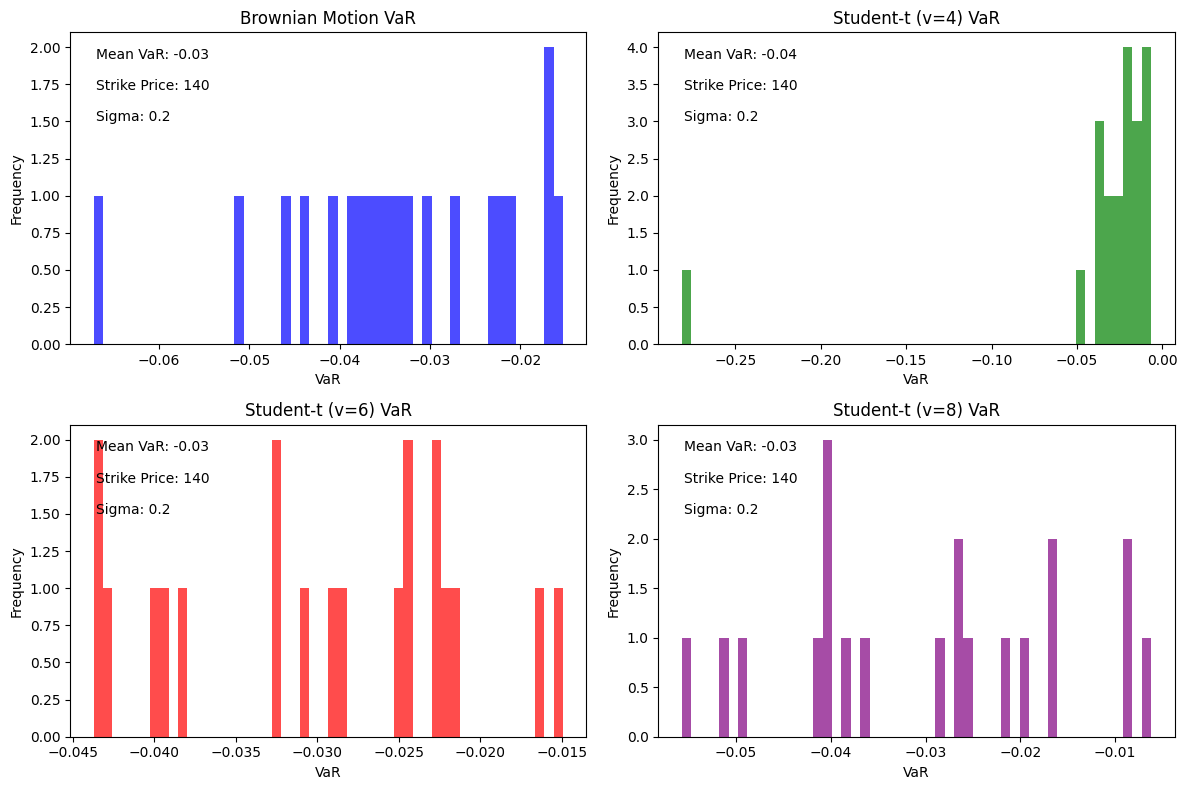

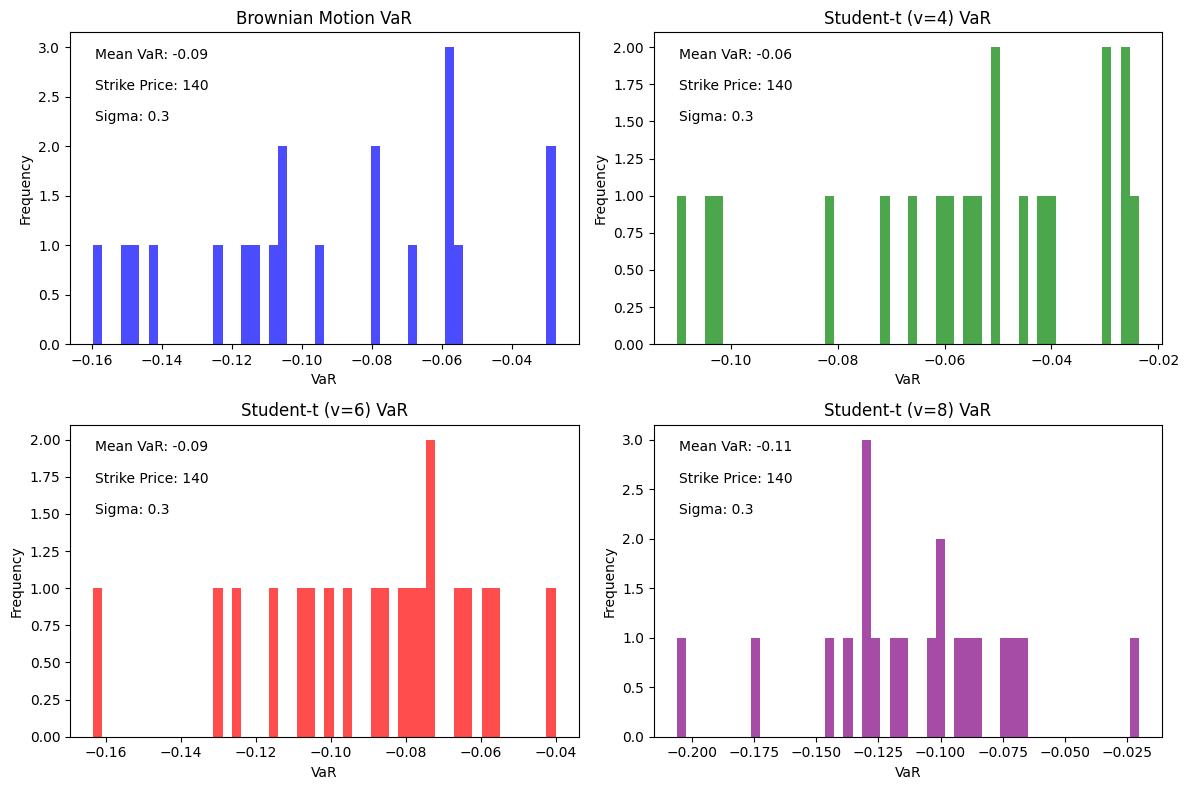

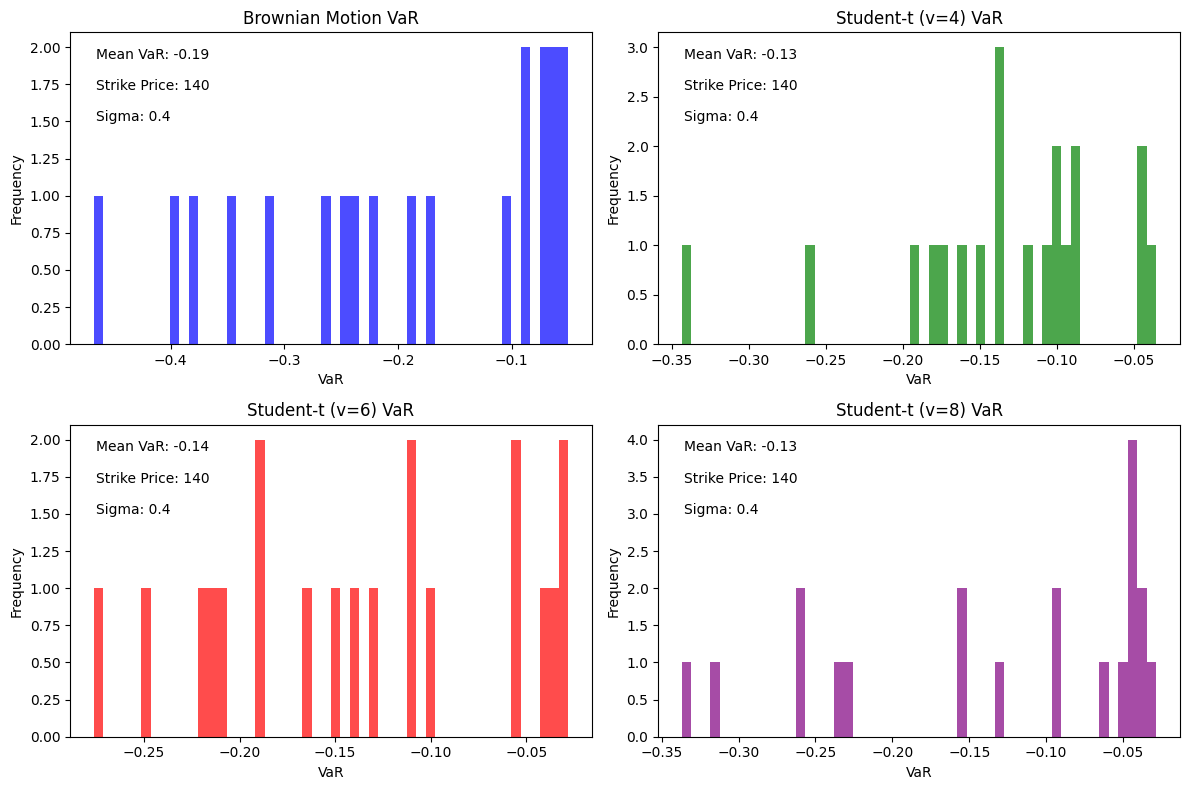

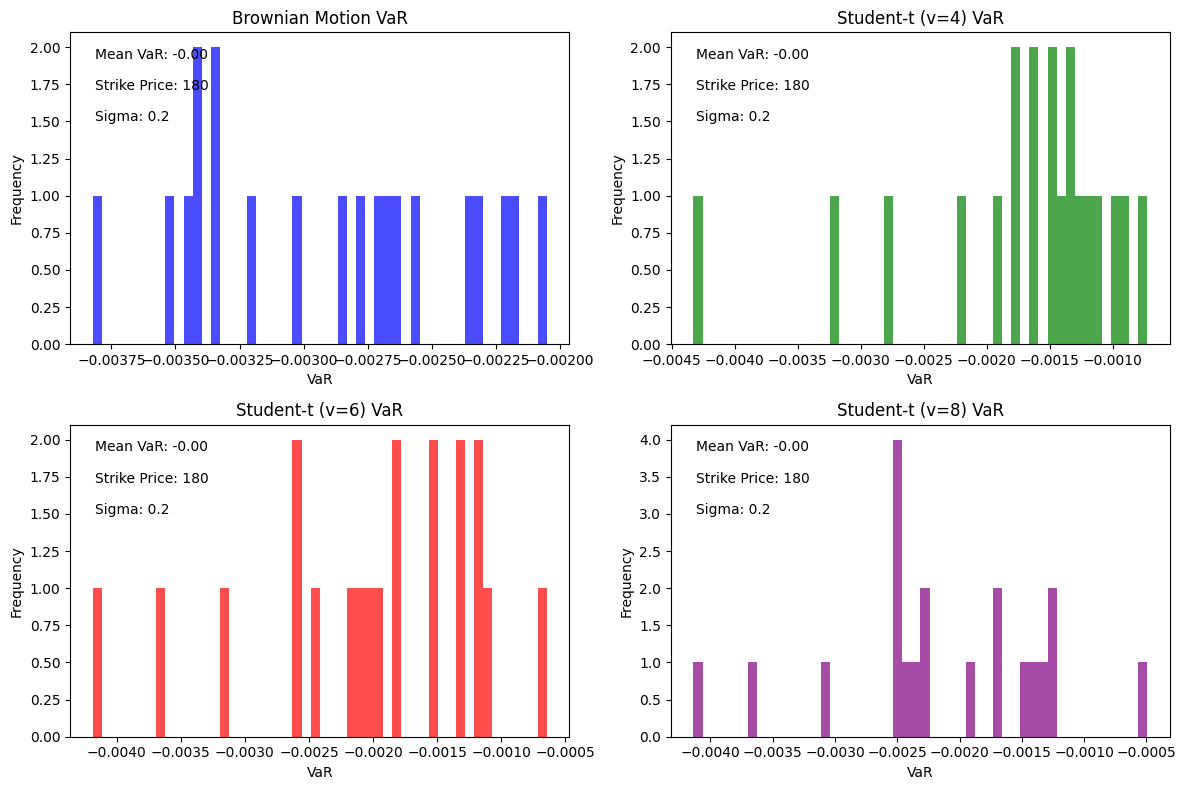

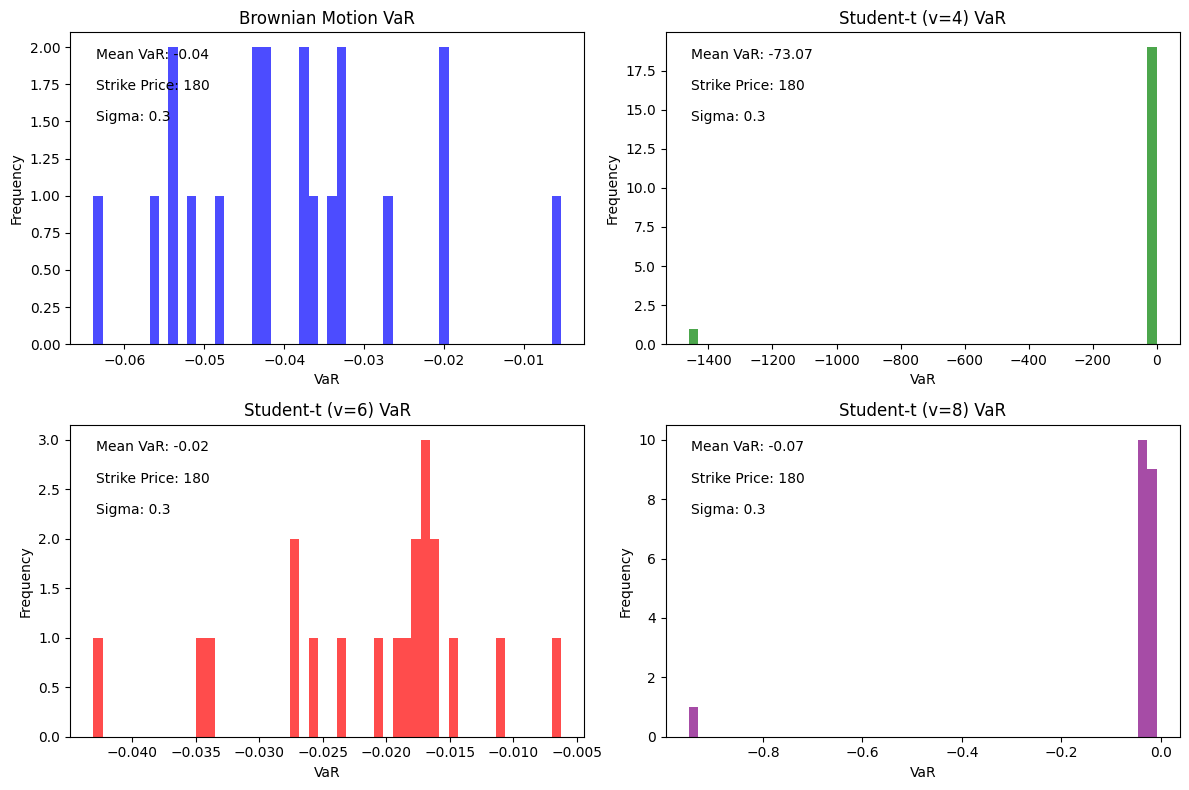

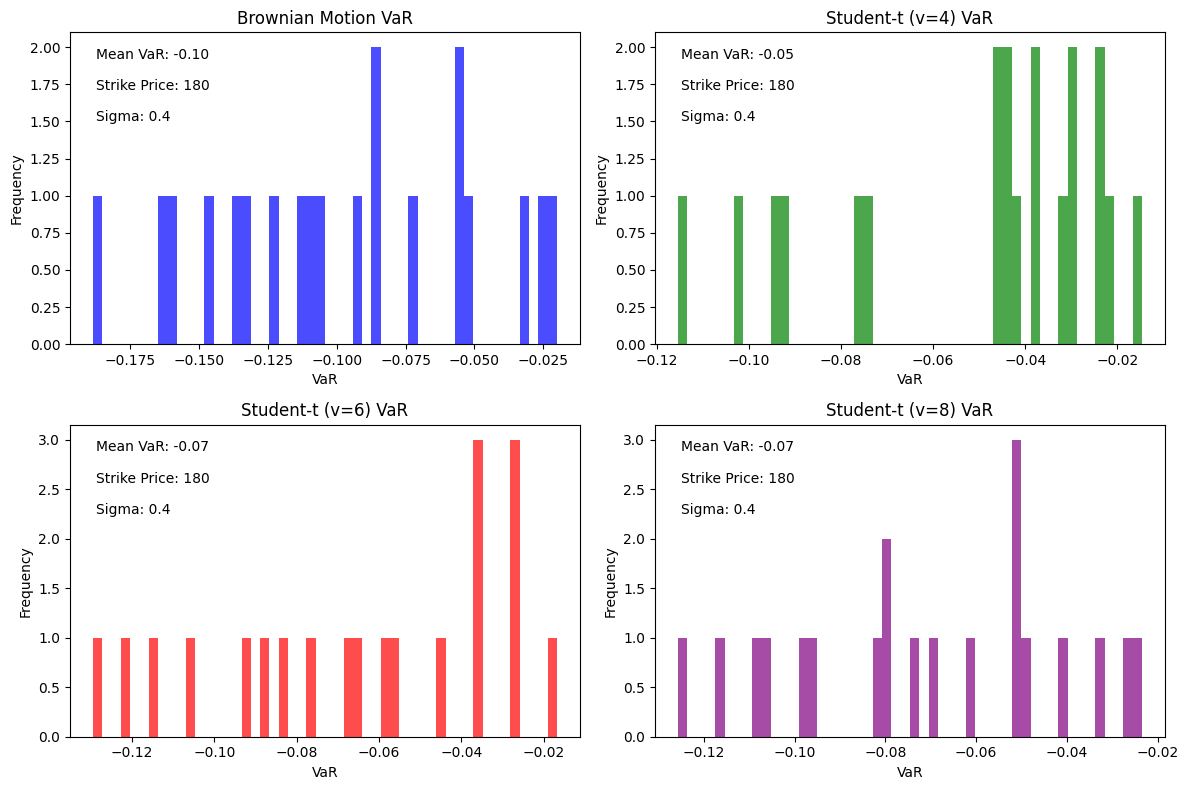

In [8]:
import matplotlib.pyplot as plt

# Example: Plotting for K=100 and sigma=0.2
for K in [100,140,180]:
    #K = 100
    for sigma in [0.2,0.3,0.4]:
    #sigma = 0.2
        key = f'K={K}_sigma={sigma}'

        # Extracting the data for the specific K and sigma
        VaRs_Brownian = results[key]['VaRs_Brownian']
        VaRs_Student_t_1 = results[key]['VaRs_Student_t_1']
        VaRs_Student_t_2 = results[key]['VaRs_Student_t_2']
        VaRs_Student_t_3 = results[key]['VaRs_Student_t_3']

        # Function to add text annotations to the plots
        def add_annotations(ax, mean_var, K, sigma):
            ax.text(0.05, 0.95, f'Mean VaR: {mean_var:.2f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')
            ax.text(0.05, 0.85, f'Strike Price: {K}', transform=ax.transAxes, fontsize=10, verticalalignment='top')
            ax.text(0.05, 0.75, f'Sigma: {sigma}', transform=ax.transAxes, fontsize=10, verticalalignment='top')

        # Plotting the histograms
        plt.figure(figsize=(12, 8))

        ax1 = plt.subplot(2, 2, 1)
        plt.hist(VaRs_Brownian, bins=50, color='blue', alpha=0.7)
        plt.xlabel('VaR')
        plt.ylabel('Frequency')
        plt.title('Brownian Motion VaR')
        add_annotations(ax1, np.mean(VaRs_Brownian), K, sigma)

        ax2 = plt.subplot(2, 2, 2)
        plt.hist(VaRs_Student_t_1, bins=50, color='green', alpha=0.7)
        plt.xlabel('VaR')
        plt.ylabel('Frequency')
        plt.title('Student-t (v=4) VaR')
        add_annotations(ax2, np.mean(VaRs_Student_t_1), K, sigma)

        ax3 = plt.subplot(2, 2, 3)
        plt.hist(VaRs_Student_t_2, bins=50, color='red', alpha=0.7)
        plt.xlabel('VaR')
        plt.ylabel('Frequency')
        plt.title('Student-t (v=6) VaR')
        add_annotations(ax3, np.mean(VaRs_Student_t_2), K, sigma)

        ax4 = plt.subplot(2, 2, 4)
        plt.hist(VaRs_Student_t_3, bins=50, color='purple', alpha=0.7)
        plt.xlabel('VaR')
        plt.ylabel('Frequency')
        plt.title('Student-t (v=8) VaR')
        add_annotations(ax4, np.mean(VaRs_Student_t_3), K, sigma)

        plt.tight_layout()
        plt.show()



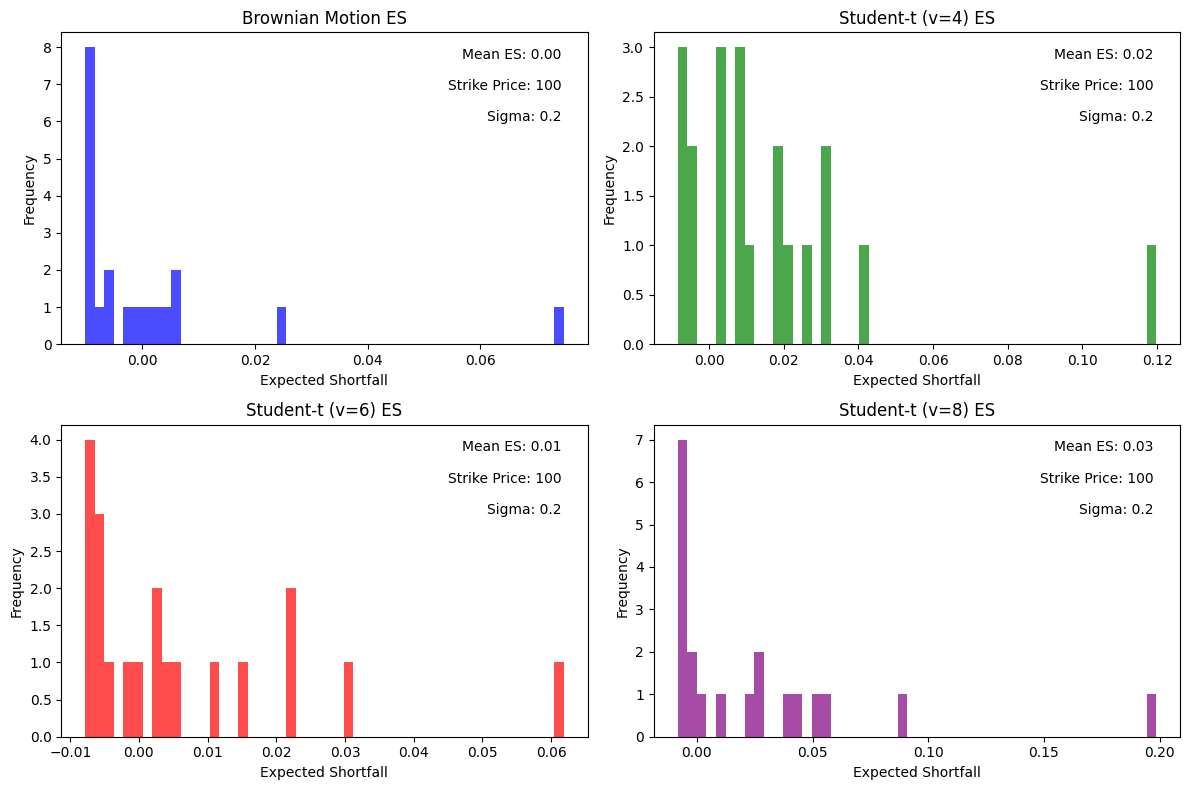

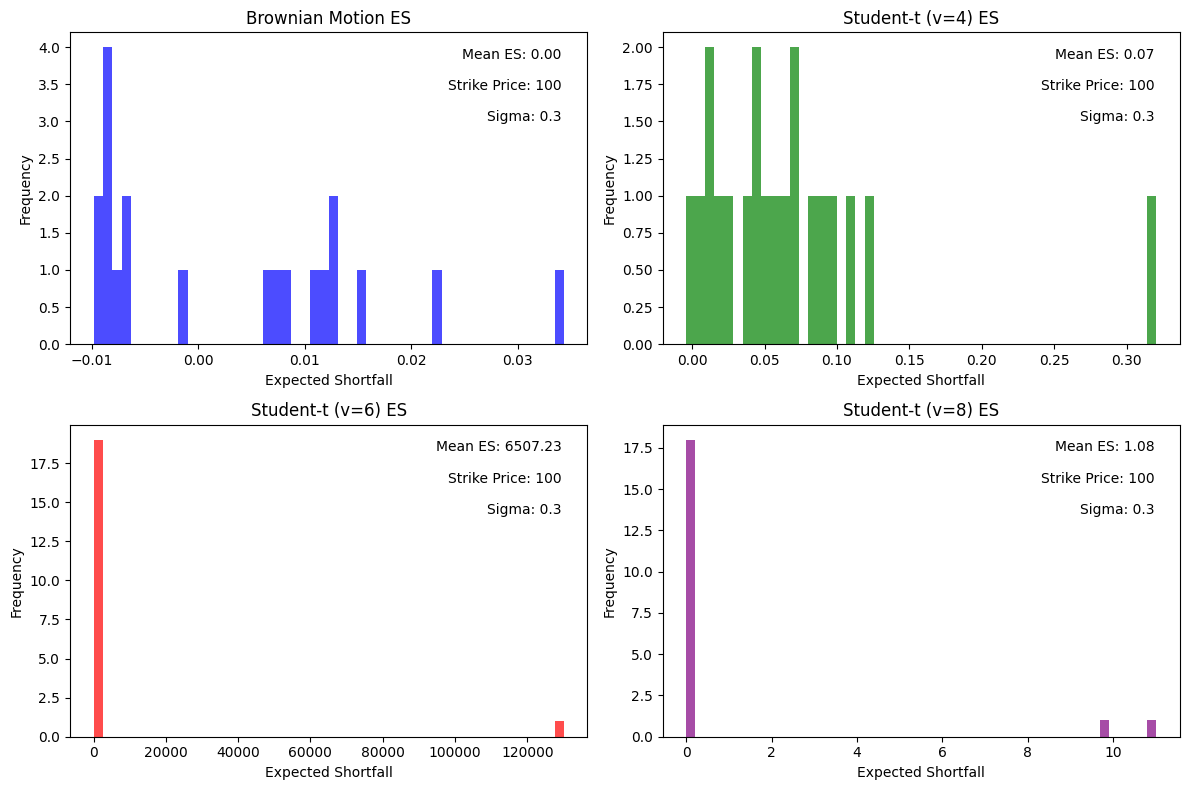

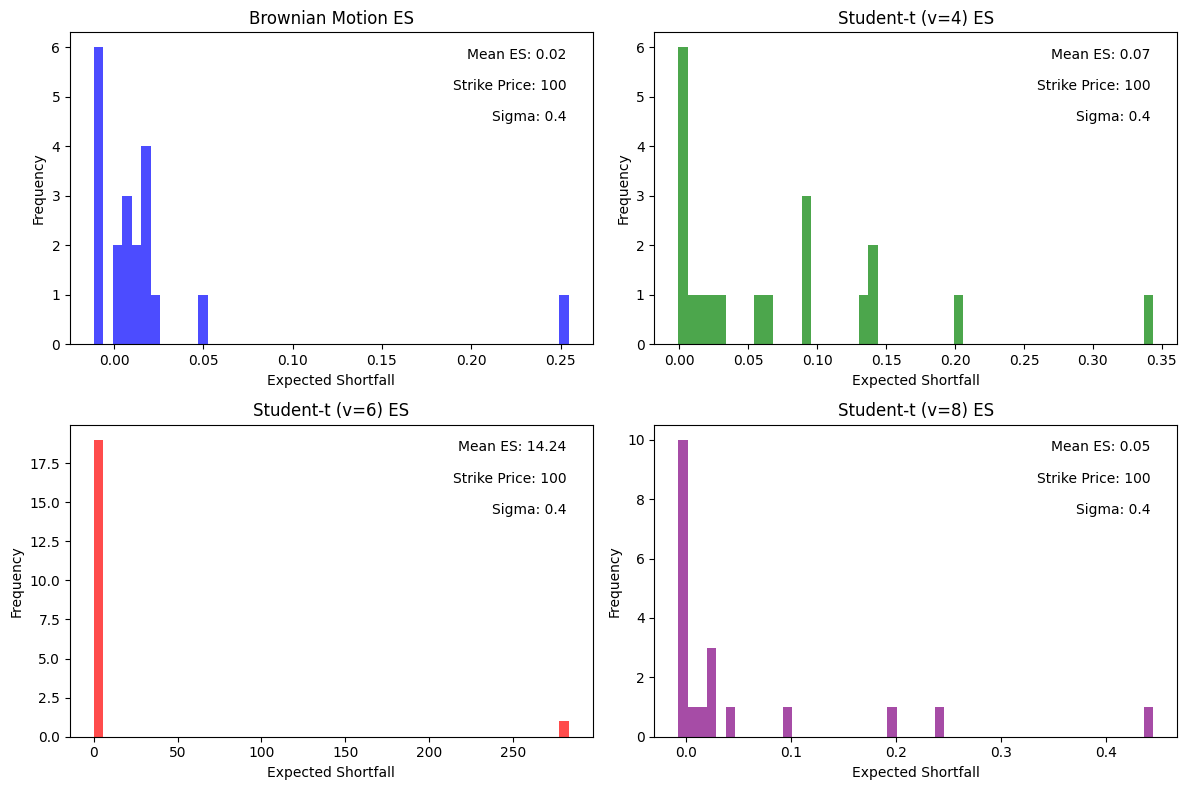

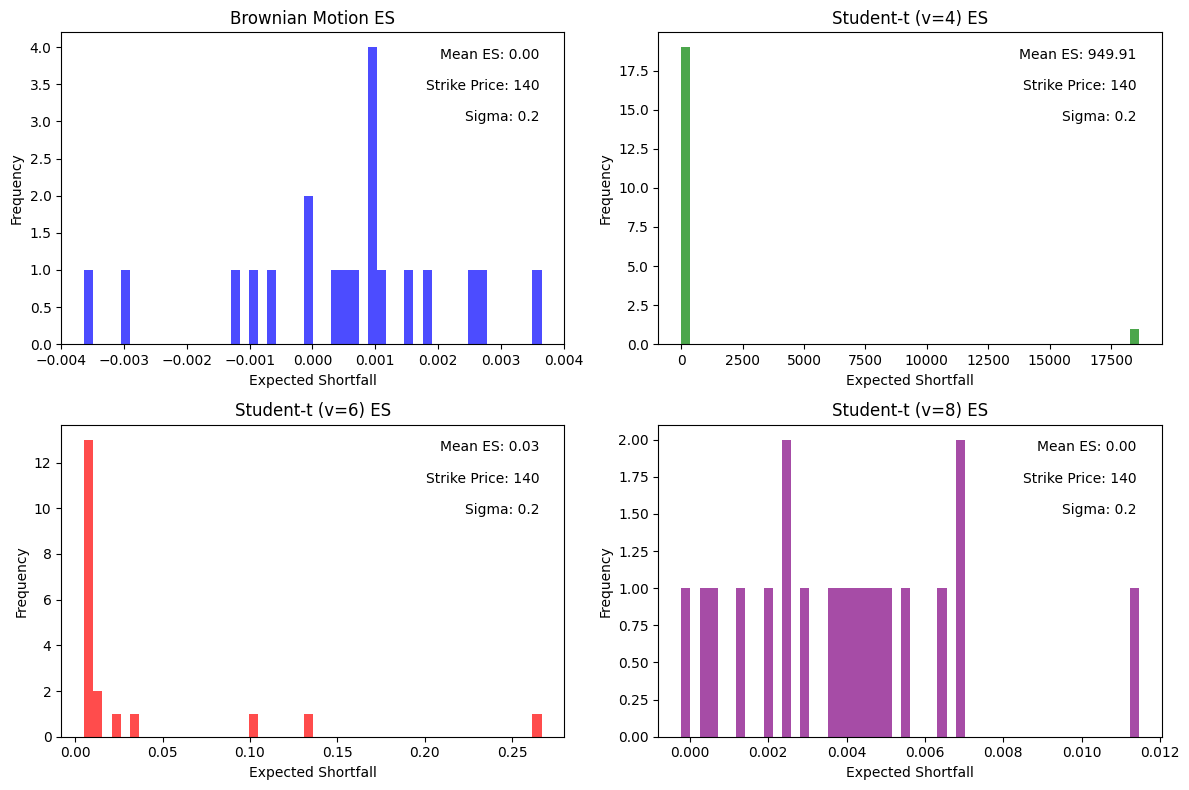

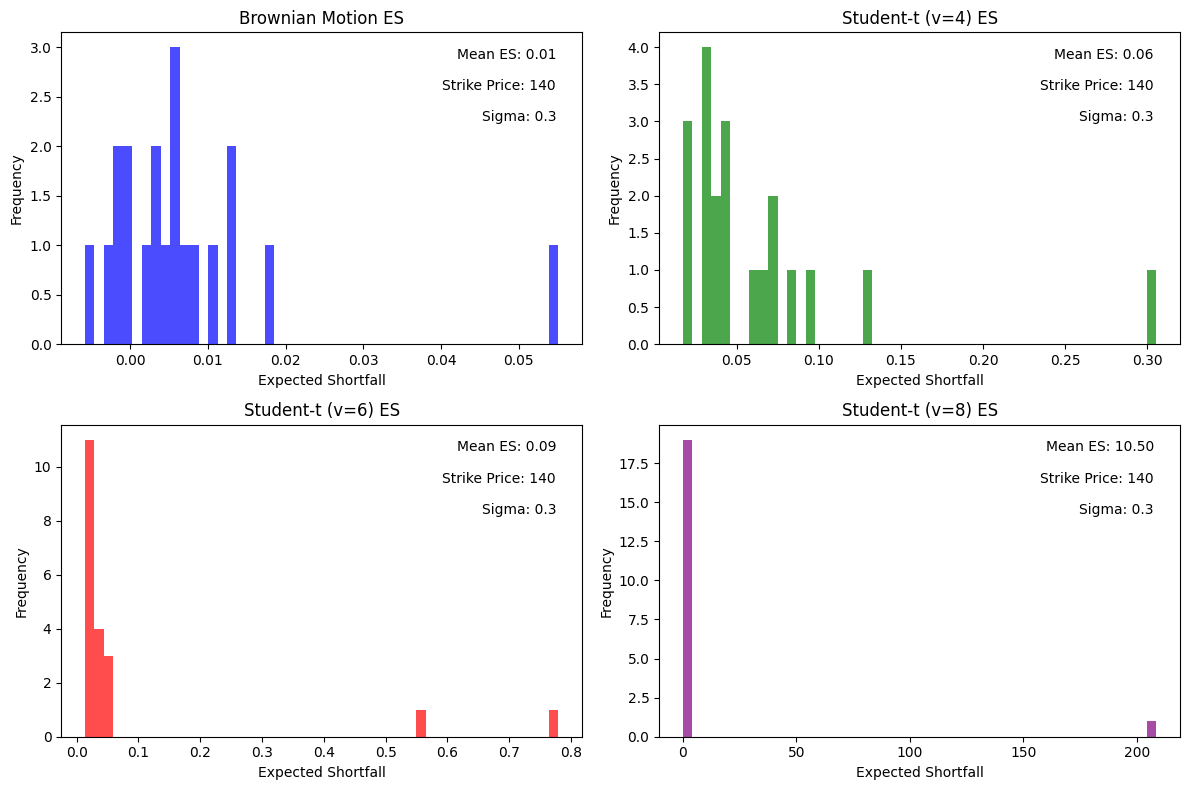

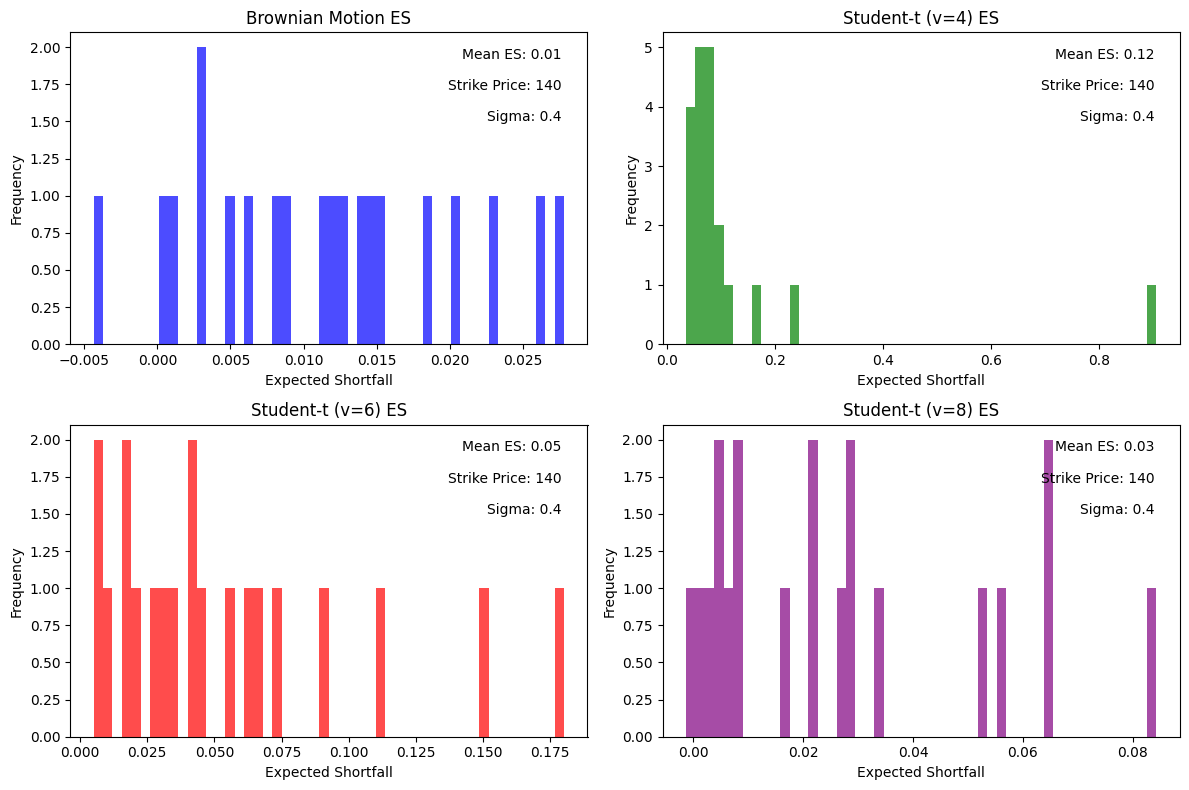

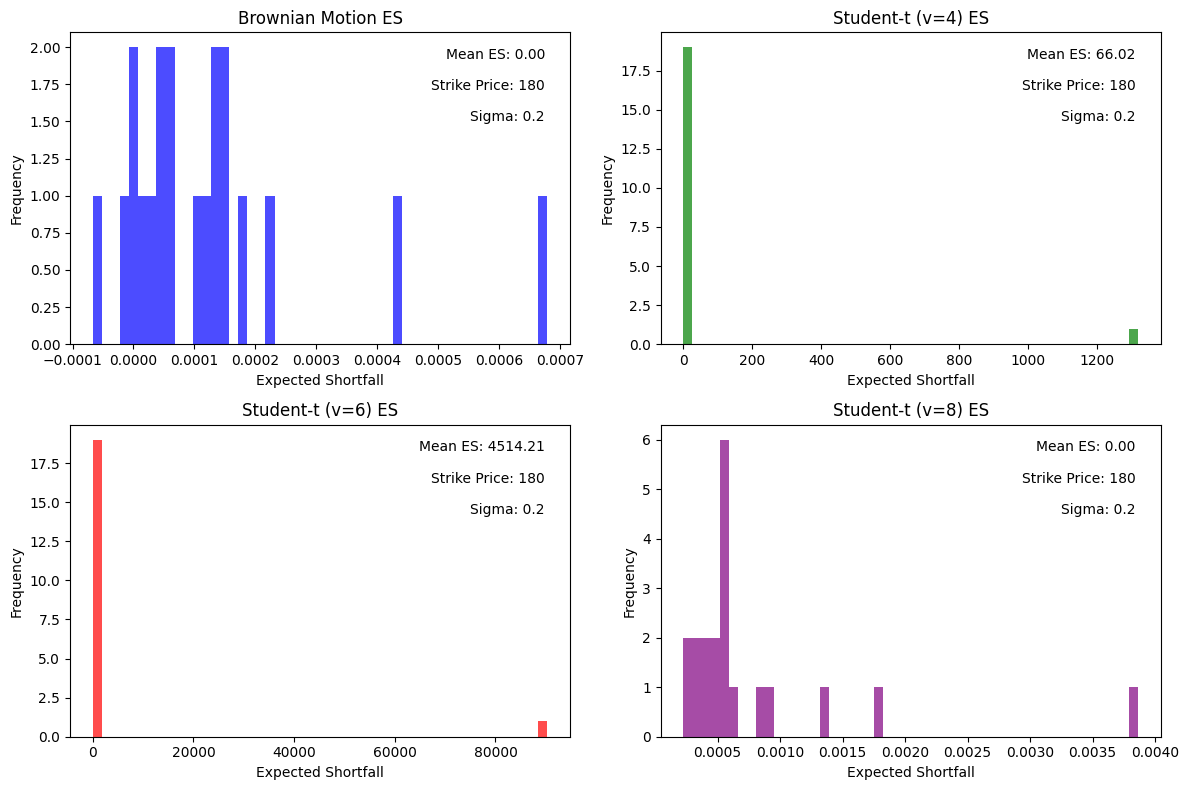

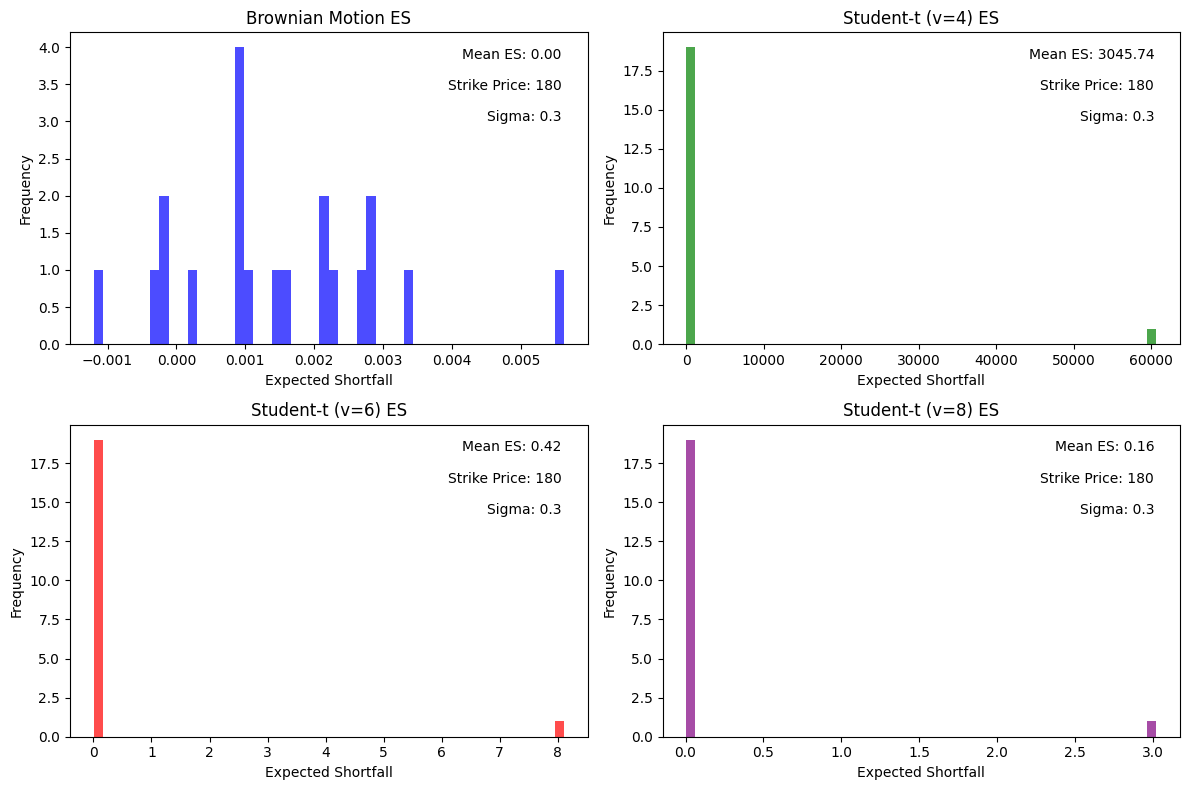

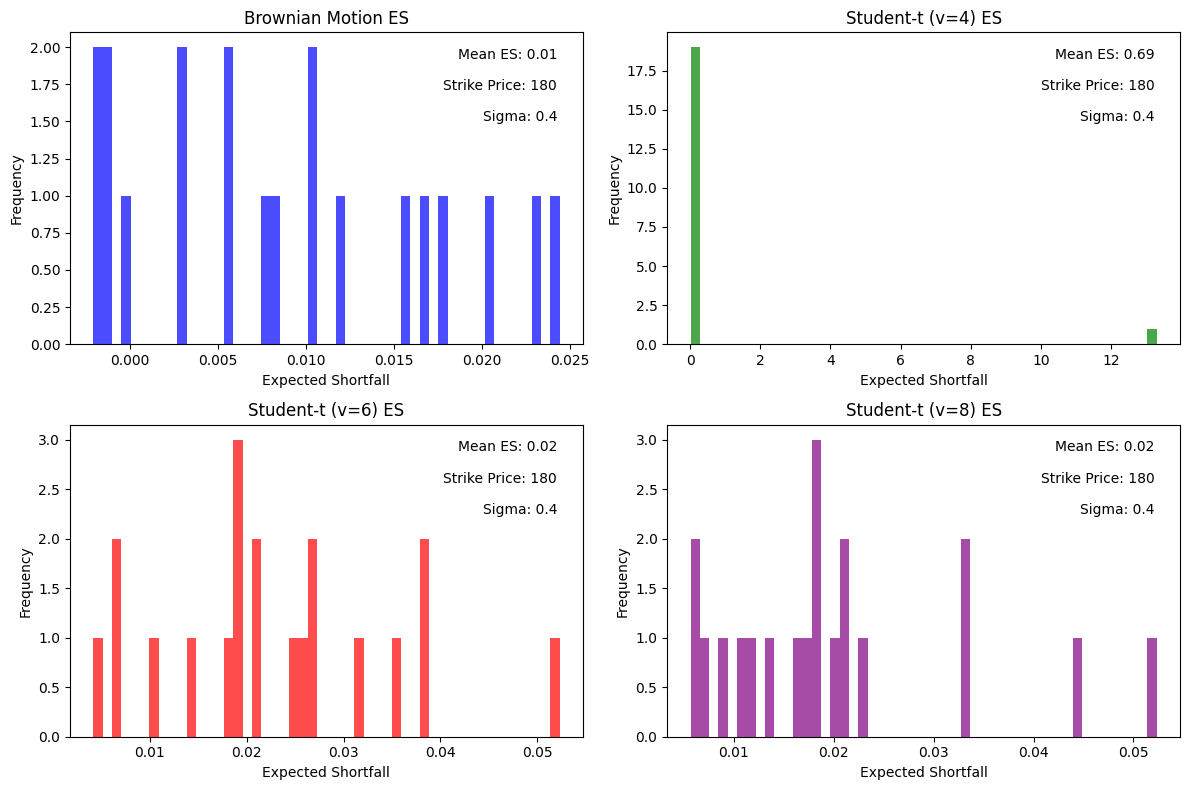

In [9]:

for K in [100,140,180]:
    #K = 100
    for sigma in [0.2,0.3,0.4]:

        key = f'K={K}_sigma={sigma}'

        # Extracting the ES data for the specific K and sigma
        ES_Brownian = results[key]['ES_Brownian']
        ES_Student_t_1 = results[key]['ES_Student_t_1']
        ES_Student_t_2 = results[key]['ES_Student_t_2']
        ES_Student_t_3 = results[key]['ES_Student_t_3']

        # Function to add text annotations to the plots
        def add_annotations(ax, mean_es, K, sigma):
            ax.text(0.95, 0.95, f'Mean ES: {mean_es:.2f}', transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right')
            ax.text(0.95, 0.85, f'Strike Price: {K}', transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right')
            ax.text(0.95, 0.75, f'Sigma: {sigma}', transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right')

        # Plotting the histograms for Expected Shortfall
        plt.figure(figsize=(12, 8))

        # Brownian Motion ES
        ax1 = plt.subplot(2, 2, 1)
        plt.hist(ES_Brownian, bins=50, color='blue', alpha=0.7)
        plt.xlabel('Expected Shortfall')
        plt.ylabel('Frequency')
        plt.title('Brownian Motion ES')
        add_annotations(ax1, np.mean(ES_Brownian), K, sigma)

        # Student-t (v=4) ES
        ax2 = plt.subplot(2, 2, 2)
        plt.hist(ES_Student_t_1, bins=50, color='green', alpha=0.7)
        plt.xlabel('Expected Shortfall')
        plt.ylabel('Frequency')
        plt.title('Student-t (v=4) ES')
        add_annotations(ax2, np.mean(ES_Student_t_1), K, sigma)

        # Student-t (v=6) ES
        ax3 = plt.subplot(2, 2, 3)
        plt.hist(ES_Student_t_2, bins=50, color='red', alpha=0.7)
        plt.xlabel('Expected Shortfall')
        plt.ylabel('Frequency')
        plt.title('Student-t (v=6) ES')
        add_annotations(ax3, np.mean(ES_Student_t_2), K, sigma)

        # Student-t (v=8) ES
        ax4 = plt.subplot(2, 2, 4)
        plt.hist(ES_Student_t_3, bins=50, color='purple', alpha=0.7)
        plt.xlabel('Expected Shortfall')
        plt.ylabel('Frequency')
        plt.title('Student-t (v=8) ES')
        add_annotations(ax4, np.mean(ES_Student_t_3), K, sigma)

        plt.tight_layout()
        plt.show()






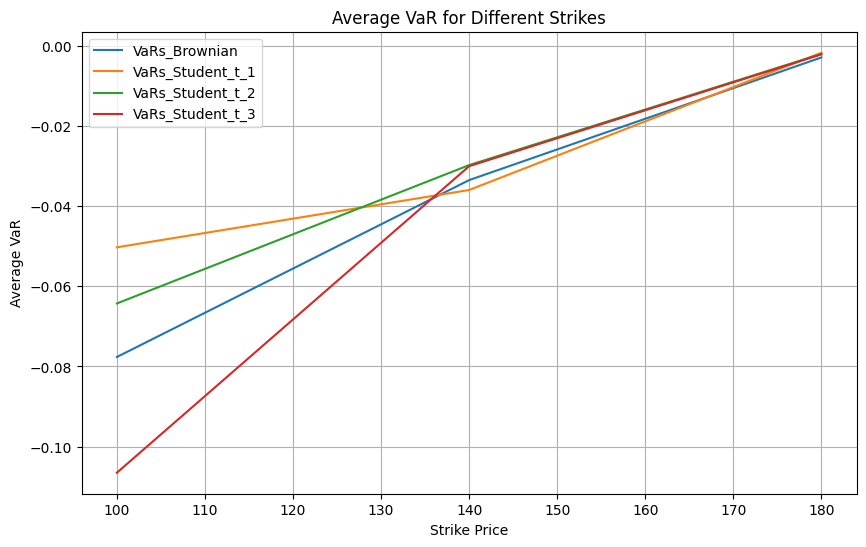

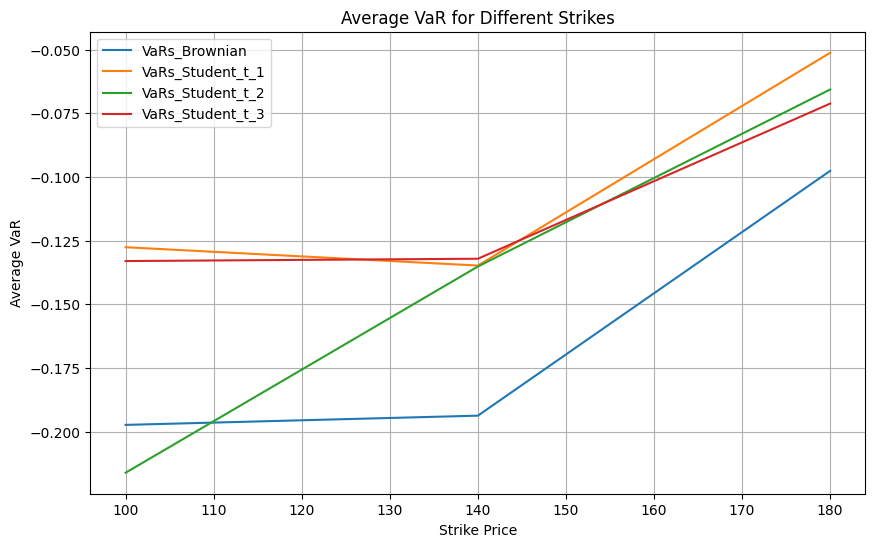

KeyError: 'K=100_sigma=0.6'

<Figure size 1000x600 with 0 Axes>

In [13]:
# plot for VaR on different strike price

strike_prices = [100,  140, 180]
for sigma in [0.2,0.4,0.6]:
    #sigma = 0.2  # Example volatility value
    distribution_types = ['VaRs_Brownian', 'VaRs_Student_t_1', 'VaRs_Student_t_2', 'VaRs_Student_t_3']

    plt.figure(figsize=(10, 6))

    for dist in distribution_types:
        avg_vars = []
        for K in strike_prices:
            key = f'K={K}_sigma={sigma}'
            avg_var = np.mean(results[key][dist])
            avg_vars.append(avg_var)
        plt.plot(strike_prices, avg_vars, label=dist)

    plt.xlabel('Strike Price')
    plt.ylabel('Average VaR')
    plt.title('Average VaR for Different Strikes')
    plt.legend()
    plt.grid(True)
    plt.show()


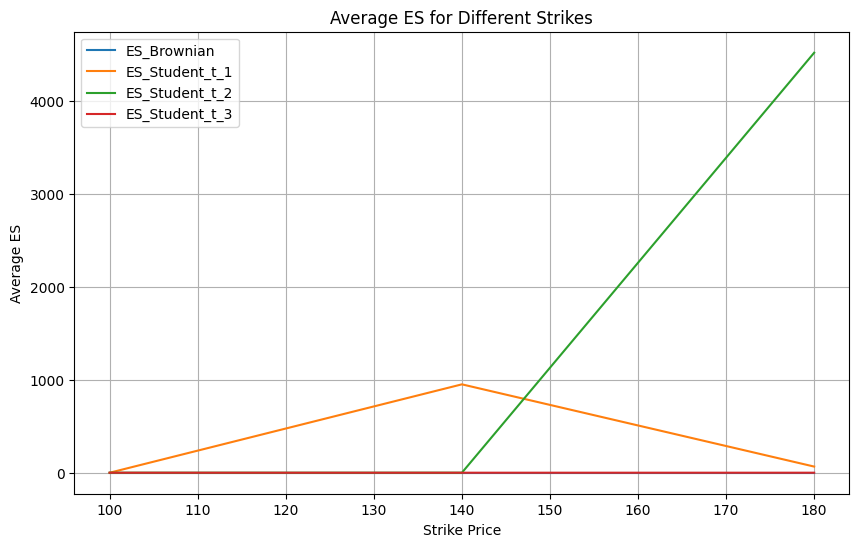

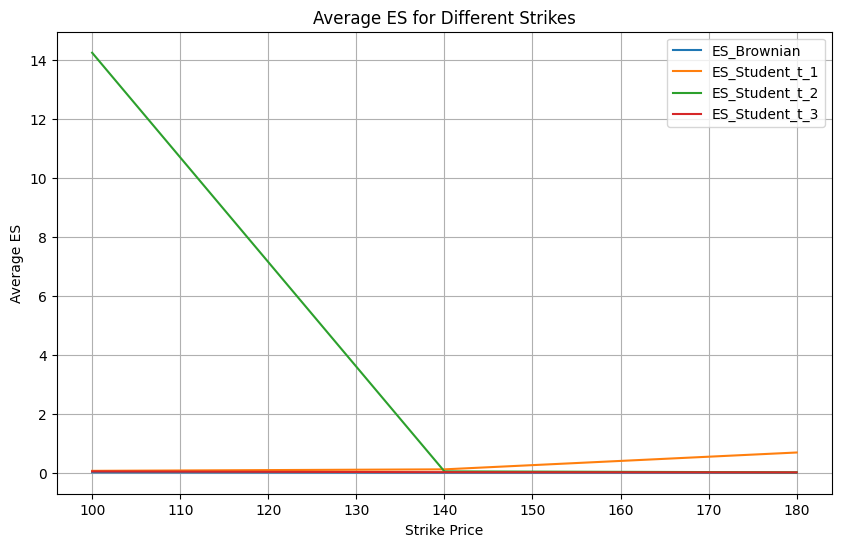

KeyError: 'K=100_sigma=0.6'

<Figure size 1000x600 with 0 Axes>

In [14]:
# ES for different strike price
strike_prices = [100,  140, 180]
for sigma in [0.2,0.4,0.6]:

    plt.figure(figsize=(10, 6))

    distribution_types = ['ES_Brownian', 'ES_Student_t_1', 'ES_Student_t_2', 'ES_Student_t_3']

    for dist in distribution_types:
        avg_es = []
        for K in strike_prices:
            key = f'K={K}_sigma={sigma}'
            avg_es_value = np.mean(results[key][dist])
            avg_es.append(avg_es_value)
        plt.plot(strike_prices, avg_es, label=dist)

    plt.xlabel('Strike Price')
    plt.ylabel('Average ES')
    plt.title('Average ES for Different Strikes')
    plt.legend()
    plt.grid(True)
    plt.show()
